In [2]:
!pip install --disable-pip-version-check -q awswrangler==2.14.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires ipywidgets<8.0.0, but you have ipywidgets 8.1.2 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.


In [3]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [53]:
import boto3
import sagemaker
from pyathena import connect

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as cm
import seaborn as sns
import plotly.express as px

from scipy import stats

import io

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

s3 = boto3.resource('s3')
sm = boto3.Session().client(service_name="sagemaker", region_name=region)
s3_client = boto3.client("s3", region_name=region)

## Store Data into S3 Data Lake ##

In [5]:
s3_source_path_csvs = "/root/OlistEcommerce/ProjectDataset/"
print(s3_source_path_csvs)

/root/OlistEcommerce/ProjectDataset/


In [6]:
s3_destination_path_csv = "s3://{}/FinalProjectDataset/csv".format(bucket)
print(s3_destination_path_csv)

s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv


In [7]:
!aws s3 cp $s3_source_path_csvs $s3_destination_path_csv/ --recursive --exclude "*" --include "*.csv"

upload: ProjectDataset/olist_order_payments_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_order_payments_dataset.csv
upload: ProjectDataset/olist_customers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_customers_dataset.csv
upload: ProjectDataset/olist_products_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_products_dataset.csv
upload: ProjectDataset/olist_geolocation_dataset2.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_geolocation_dataset2.csv
upload: ProjectDataset/olist_sellers_dataset.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/olist_sellers_dataset.csv
upload: ProjectDataset/product_category_name_translation.csv to s3://sagemaker-us-east-1-757088774357/FinalProjectDataset/csv/product_category_name_translation.csv
upload: ProjectDataset/olist_geolocation_dataset1.csv to s3://sagemaker-us-east-1-757088774357/FinalProjec

In [8]:
# Confirm that all data was uploaded
!aws s3 ls $s3_destination_path_csv/

                           PRE /
2024-05-30 03:10:55    9033957 olist_customers_dataset.csv
2024-05-30 03:10:55   23400724 olist_geolocation_dataset1.csv
2024-05-30 03:10:55   23582346 olist_geolocation_dataset2.csv
2024-05-30 03:10:55   15438671 olist_order_items_dataset.csv
2024-05-30 03:10:55    5777138 olist_order_payments_dataset.csv
2024-05-30 03:10:55   14451670 olist_order_reviews_dataset.csv
2024-05-30 03:10:56   17654914 olist_orders_dataset.csv
2024-05-30 03:10:56    2379446 olist_products_dataset.csv
2024-05-30 03:10:56     174703 olist_sellers_dataset.csv
2024-05-30 03:10:56       2613 product_category_name_translation.csv


## Setup PyAthena ##

In [9]:
db_name = "olist_ecommerce_aws"

In [10]:
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
print(s3_staging_dir)

s3://sagemaker-us-east-1-757088774357/athena/staging


In [11]:
# Establish Connection to Athena Staging Directory in S3
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [12]:
# Create the Olist Ecommerce AWS DB if One Does not Exist
statement = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)
pd.read_sql(statement, conn)

""


In [13]:
# Ensure DB Now Exists or Already Existed
statement = "SHOW DATABASES"
df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,olist_ecommerce_aws
2,sagemaker_featurestore


### Create Table in PyAthena ###

In [14]:
### NOTE: Skipped for Now

## Perform EDA Using Data Lake ##

In [15]:
print(bucket)

sagemaker-us-east-1-757088774357


In [16]:
customer_data_object = s3_client.get_object(Bucket=bucket, Key=
    "FinalProjectDataset/csv/olist_customers_dataset.csv"
)
geolocation_data_object1 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset1.csv"
))
geolocation_data_object2 = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_geolocation_dataset2.csv"
))
items_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_items_dataset.csv"
))
order_payments_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_payments_dataset.csv"
))
order_reviews_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_order_reviews_dataset.csv"
))
orders_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_orders_dataset.csv"
))
products_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_products_dataset.csv"
))
sellers_data_object = s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/olist_sellers_dataset.csv"
))
product_category_name_translation_data_object= s3_client.get_object(Bucket=bucket, Key=(
    "FinalProjectDataset/csv/product_category_name_translation.csv"
))

customer_data = pd.read_csv(io.BytesIO(customer_data_object["Body"].read()))
geolocation_data1 = pd.read_csv(io.BytesIO(geolocation_data_object1["Body"].read()))
geolocation_data2 = pd.read_csv(io.BytesIO(geolocation_data_object2["Body"].read()))
order_items_data = pd.read_csv(io.BytesIO(items_data_object["Body"].read()))
order_payments_data = pd.read_csv(io.BytesIO(order_payments_data_object["Body"].read()))
order_reviews_data = pd.read_csv(io.BytesIO(order_reviews_data_object["Body"].read()))
orders_data = pd.read_csv(io.BytesIO(orders_data_object["Body"].read()))
products_data = pd.read_csv(io.BytesIO(products_data_object["Body"].read()))
sellers_data = pd.read_csv(io.BytesIO(sellers_data_object["Body"].read()))
product_category_name_translation_data = pd.read_csv(io.BytesIO(product_category_name_translation_data_object["Body"].read()))

In [17]:
# List of DataFrame names
dataframe_names = [
    "customer_data", "geolocation_data1", "geolocation_data2", "order_items_data", "order_payments_data",
    "order_reviews_data", "orders_data", "products_data", "sellers_data", "product_category_name_translation_data"
]

# Iterate over DataFrame names and print the head of each DataFrame to Ensure Data is Captured
for df_name in dataframe_names:
    print(f"Head of DataFrame: {df_name}")
    print(eval(df_name).head(5))  # Print the head of each DataFrame
    print("\n")

Head of DataFrame: customer_data
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  


Head of DataFrame: geolocation_data1
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0            

In [18]:
print(dataframe_names)

['customer_data', 'geolocation_data1', 'geolocation_data2', 'order_items_data', 'order_payments_data', 'order_reviews_data', 'orders_data', 'products_data', 'sellers_data', 'product_category_name_translation_data']


In [19]:
products_data.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [20]:
# Merge Data on Order ID
ecommerce_df = orders_data.merge(order_items_data, on='order_id', how='left')
ecommerce_df = ecommerce_df.merge(order_payments_data, on='order_id', how='outer', validate='m:m')
ecommerce_df = ecommerce_df.merge(order_reviews_data, on='order_id', how='outer')

# Merge Data on Product ID
ecommerce_df = ecommerce_df.merge(products_data, on='product_id', how='outer')

# Merge Data on Customer ID
ecommerce_df = ecommerce_df.merge(customer_data, on='customer_id', how='outer')

# Merge Data on Seller ID
ecommerce_df = ecommerce_df.merge(sellers_data, on='seller_id', how='outer')

In [21]:
ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [22]:
# Print the data types of each column in the DataFrame
print("\nData types of ecommerce_df:")
print(ecommerce_df.dtypes)


Data types of ecommerce_df:
order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
review_id                         object
review_score                     float64
review_comment_title              object
review_comment_message            object
review_creation_date              object
review_answer_timestamp     

In [23]:
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
    
df_summary(ecommerce_df)

Dataset Shape: (119143, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,16.46
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,16.46
2,order_status,object,0,8,delivered,0.25
3,order_purchase_timestamp,object,0,98875,2017-10-02 10:56:33,16.44
4,order_approved_at,object,177,90733,2017-10-02 11:07:15,16.28
5,order_delivered_carrier_date,object,2086,81018,2017-10-04 19:55:00,16.03
6,order_delivered_customer_date,object,3421,95664,2017-10-10 21:25:13,16.40
7,order_estimated_delivery_date,object,0,459,2017-10-18 00:00:00,8.47
8,order_item_id,float64,833,21,1.0,0.72
9,product_id,object,833,32951,87285b34884572647811a353c7ac498a,13.63


In [24]:
datetime_columns = [col for col in ecommerce_df.columns if any(keyword in col for keyword in ['timestamp', 'date', 'approved_at'])]

# Print the identified datetime columns
print("Datetime columns identified:")
print(datetime_columns)


Datetime columns identified:
['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']


In [25]:
# Concert to DateTime Types
ecommerce_df[datetime_columns] = ecommerce_df[datetime_columns].apply(pd.to_datetime)

ecommerce_df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP


In [26]:
df_summary(ecommerce_df)

Dataset Shape: (119143, 39)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,order_id,object,0,99441,e481f51cbdc54678b7cc49136f2d6af7,16.46
1,customer_id,object,0,99441,9ef432eb6251297304e76186b10a928d,16.46
2,order_status,object,0,8,delivered,0.25
3,order_purchase_timestamp,datetime64[ns],0,98875,2017-10-02 10:56:33,16.44
4,order_approved_at,datetime64[ns],177,90733,2017-10-02 11:07:15,16.28
5,order_delivered_carrier_date,datetime64[ns],2086,81018,2017-10-04 19:55:00,16.03
6,order_delivered_customer_date,datetime64[ns],3421,95664,2017-10-10 21:25:13,16.40
7,order_estimated_delivery_date,datetime64[ns],0,459,2017-10-18 00:00:00,8.47
8,order_item_id,float64,833,21,1.0,0.72
9,product_id,object,833,32951,87285b34884572647811a353c7ac498a,13.63


In [40]:
# Identify numerical columns
numerical_columns = ecommerce_df.select_dtypes(include=['number']).columns.tolist()

# Filter out columns that contain 'zip_code' and 'item_id' in their names
numerical_columns = [col for col in numerical_columns if 'zip_code' not in col and 'item_id' not in col]

# Print the identified numerical columns
print("Numerical columns identified:")
print(numerical_columns)

Numerical columns identified:
['price', 'freight_value', 'payment_sequential', 'payment_installments', 'payment_value', 'review_score', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']


In [43]:
numeric_df = ecommerce_df[numerical_columns]
corr = numeric_df.corr()

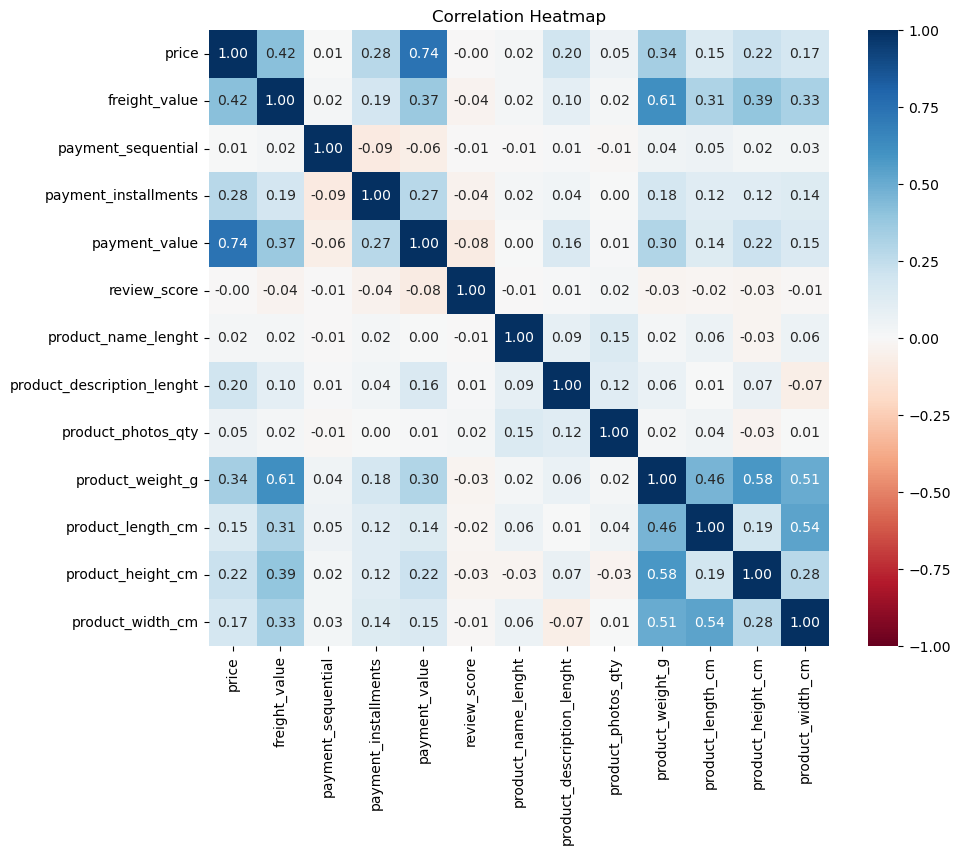

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

#### the price, freight value (transportation and delivery cost), and product weight are most correlated with the payment value ####

In [45]:
corr_payment_value = corr.loc[(corr['payment_value'] > 0.3) | (corr['payment_value'] <= -0.3)]
corr_payment_value

,price,freight_value,payment_sequential,payment_installments,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
price,1.000000,0.415938,0.006839,0.277642,0.739236,-0.004492,0.018026,0.201759,0.052818,0.339367,0.145587,0.224309,0.172629
freight_value,0.415938,1.000000,0.022345,0.185674,0.373762,-0.037013,0.022628,0.096506,0.022329,0.611587,0.309672,0.393865,0.325325
payment_value,0.739236,0.373762,-0.064467,0.273647,1.000000,-0.082343,0.002371,0.156108,0.010075,0.303326,0.138755,0.217155,0.148606
product_weight_g,0.339367,0.611587,0.043985,0.177491,0.303326,-0.028622,0.020736,0.063577,0.021535,1.000000,0.463108,0.581970,0.506897


In [46]:
summary_temp=ecommerce_df.copy()
summary_temp['order_purchase_date']=ecommerce_df['order_purchase_timestamp'].dt.date
order_counts = summary_temp.groupby('order_purchase_date').size().reset_index(name='order_count')
order_counts.head(5)

,order_purchase_date,order_count
0,2016-09-04,2
1,2016-09-05,1
2,2016-09-13,1
3,2016-09-15,3
4,2016-10-02,1


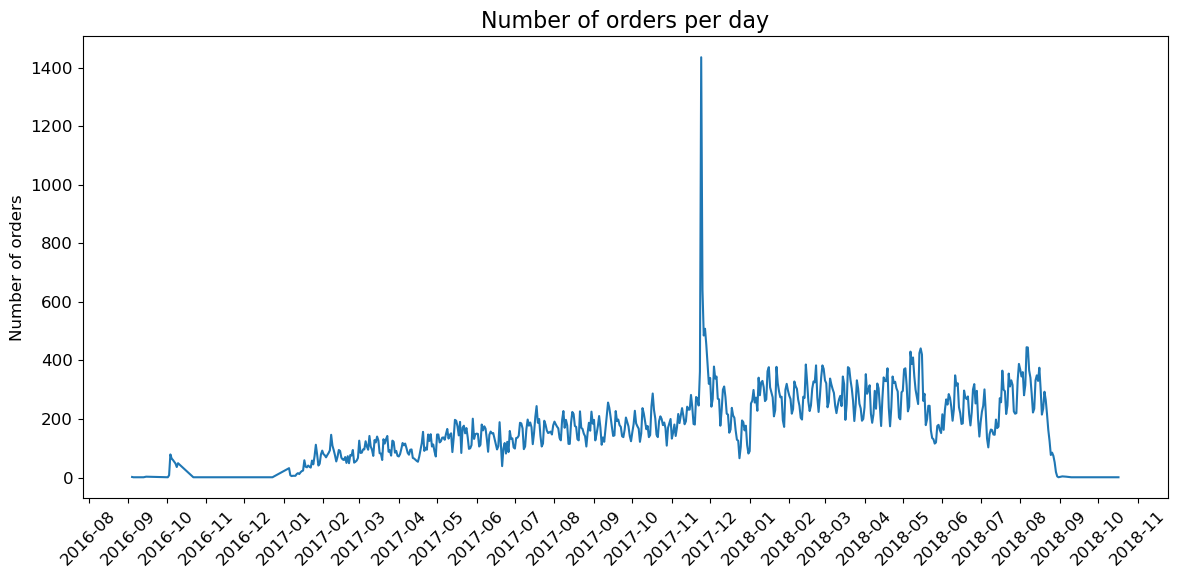

In [48]:
# Increase the default font size globally
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16

# Line plot
plt.figure(figsize=(14, 6))
plt.plot(pd.to_datetime(order_counts['order_purchase_date']), order_counts['order_count'])
plt.ylabel('Number of orders')
plt.title('Number of orders per day')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

#### We can see there's a large spike of orders around Christmas, specifically on the 24th of december. The number of orders also seems to be increasing steadily over time ####

### Check Seasonality of Transporation Prices and Product Prices ###

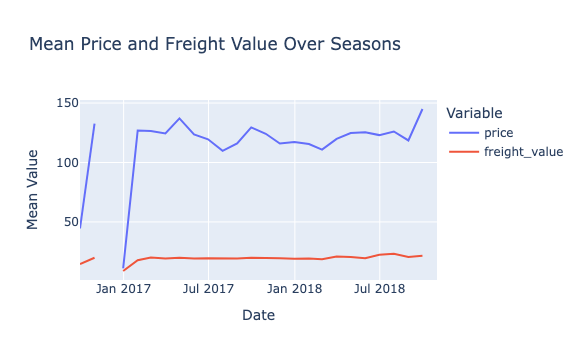

In [57]:
# Convert 'order_purchase_timestamp' to datetime type
ecommerce_df['order_purchase_timestamp'] = pd.to_datetime(ecommerce_df['order_purchase_timestamp'])

# Extract relevant columns
relevant_columns = ['price', 'freight_value', 'order_purchase_timestamp']
data = ecommerce_df[relevant_columns]

# Group data by datetime_column and aggregate price and freight_value
grouped_data = data.groupby(pd.Grouper(key='order_purchase_timestamp', freq='M')).agg({'price': 'mean', 'freight_value': 'mean'}).reset_index()

# Melt the DataFrame to long format for Plotly plotting
melted_data = pd.melt(grouped_data, id_vars='order_purchase_timestamp', value_vars=['price', 'freight_value'], var_name='Variable', value_name='Mean Value')

# Create an interactive line plot with Plotly
fig = px.line(melted_data, x='order_purchase_timestamp', y='Mean Value', color='Variable',
              title='Mean Price and Freight Value Over Seasons', labels={'order_purchase_timestamp': 'Date', 'Mean Value': 'Mean Value', 'Variable': 'Variable'})

# Show the plot
fig.show()

In [16]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>